# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from tensorflow.keras.models import load_model

# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
target_dir = "/content/drive/MyDrive/data/varsity/"
os.makedirs(target_dir, exist_ok=True)

In [ ]:
# sir uncomment it to download
# !wget https://raw.githubusercontent.com/yiminghzc/MDST-GNN/main/MDST-GNN/data/traffic.txt.gz -P /content/drive/MyDrive/data/varsity/

--2025-08-31 05:22:23--  https://raw.githubusercontent.com/yiminghzc/MDST-GNN/main/MDST-GNN/data/traffic.txt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29310512 (28M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/data/varsity/traffic.txt.gz’

traffic.txt.gz      100%[===================>]  27.95M  73.6MB/s    in 0.4s    

2025-08-31 05:22:24 (73.6 MB/s) - ‘/content/drive/MyDrive/data/varsity/traffic.txt.gz’ saved [29310512/29310512]



In [ ]:
file_path = '/content/drive/MyDrive/data/varsity/traffic.txt.gz'
df = pd.read_csv(file_path, compression='gzip', header=None)

# EDA

The dataset contains electricity consumption (in kWh) from 321 clients (nodes), recorded every 15 minutes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Columns: 862 entries, 0 to 861
dtypes: float64(862)
memory usage: 115.4 MB


In [ ]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,852,853,854,855,856,857,858,859,860,861
0,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,0.0375,...,0.0051,0.0051,0.0074,0.0079,0.0051,0.0051,0.0339,0.0051,0.0100,0.0121
1,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,0.0381,...,0.0036,0.0036,0.0107,0.0058,0.0036,0.0036,0.0348,0.0036,0.0087,0.0136
2,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,0.0309,...,0.0030,0.0030,0.0043,0.0050,0.0030,0.0030,0.0327,0.0030,0.0061,0.0107
3,0.0039,0.0060,0.0218,0.0090,0.0029,0.0118,0.0088,0.0163,0.0211,0.0199,...,0.0033,0.0033,0.0019,0.0052,0.0033,0.0033,0.0292,0.0033,0.0040,0.0071
4,0.0042,0.0055,0.0191,0.0082,0.0024,0.0095,0.0064,0.0087,0.0144,0.0226,...,0.0049,0.0049,0.0011,0.0071,0.0049,0.0049,0.0264,0.0049,0.0040,0.0039


In [ ]:
24*60/5

288.0

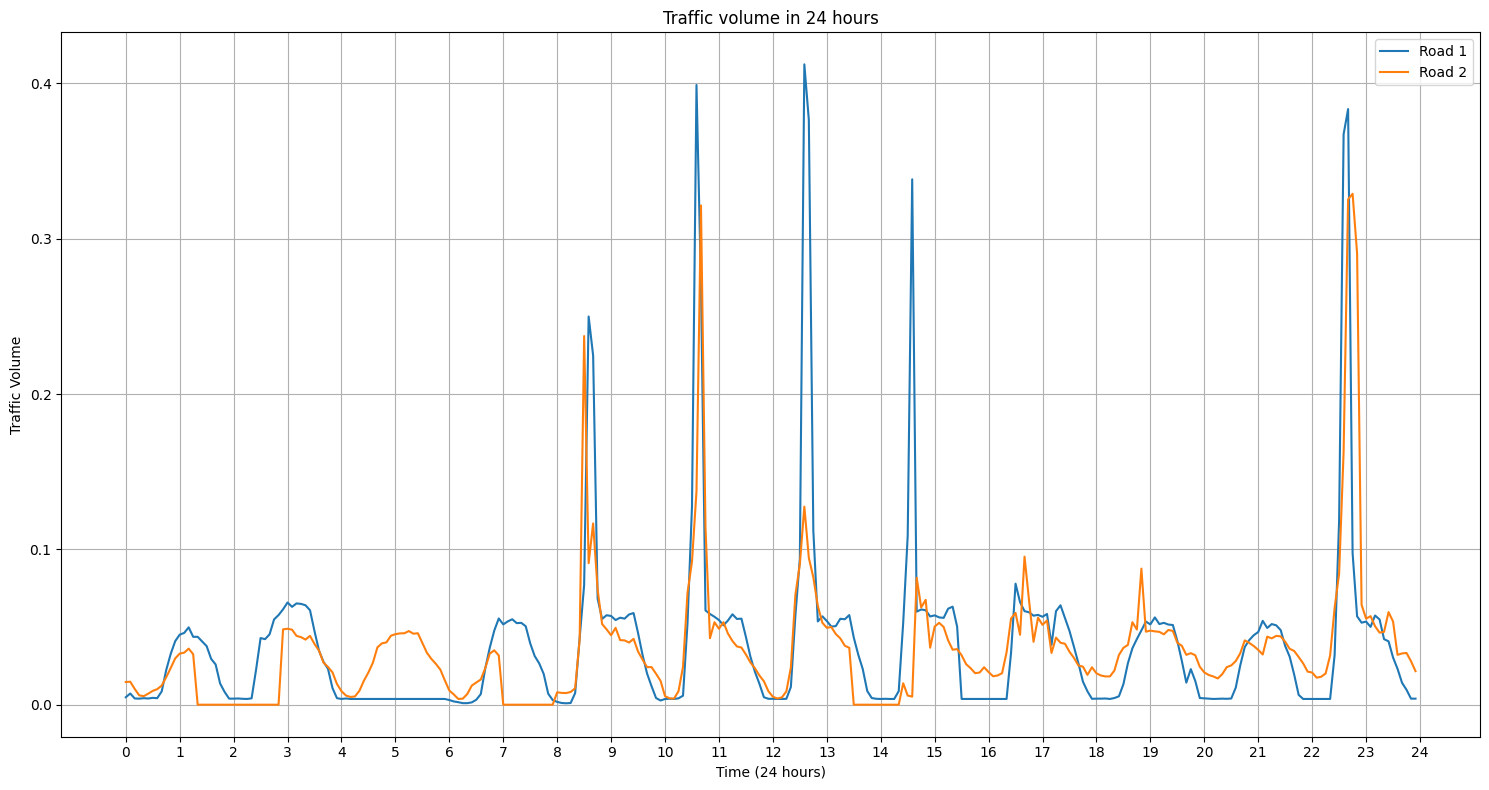

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(df.iloc[:288, 0])
plt.plot(df.iloc[:288, 1])
plt.title('Traffic volume in 24 hours')
plt.xlabel('Time (24 hours)')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.xticks(np.arange(0, 289, 12), np.arange(0, 25, 1))
plt.legend(['Road 1', 'Road 2'])
plt.tight_layout()
plt.show()


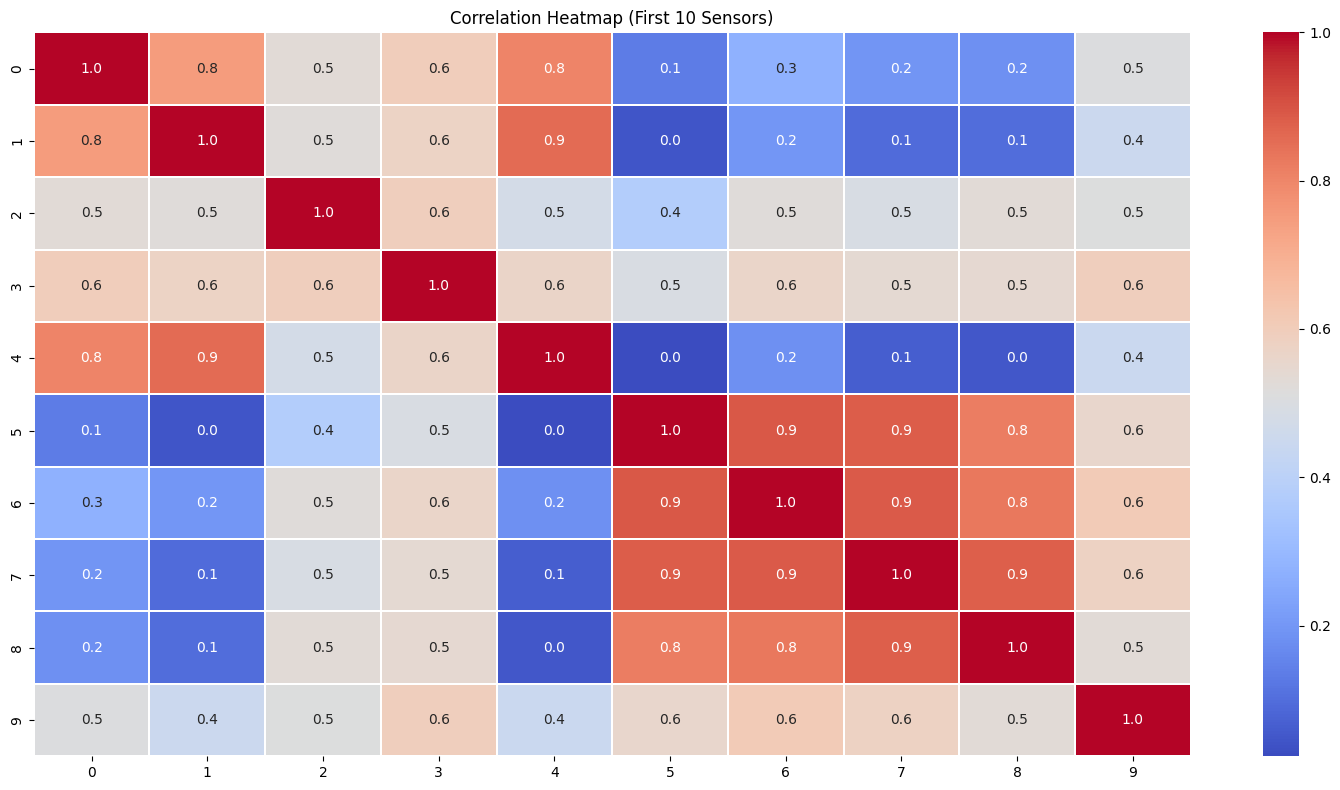

In [ ]:
correlation_subset = df.iloc[:, :10].corr()
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', linewidths=0.2, fmt='.1f')
plt.title('Correlation Heatmap (First 10 Sensors)')
plt.tight_layout()
plt.show()


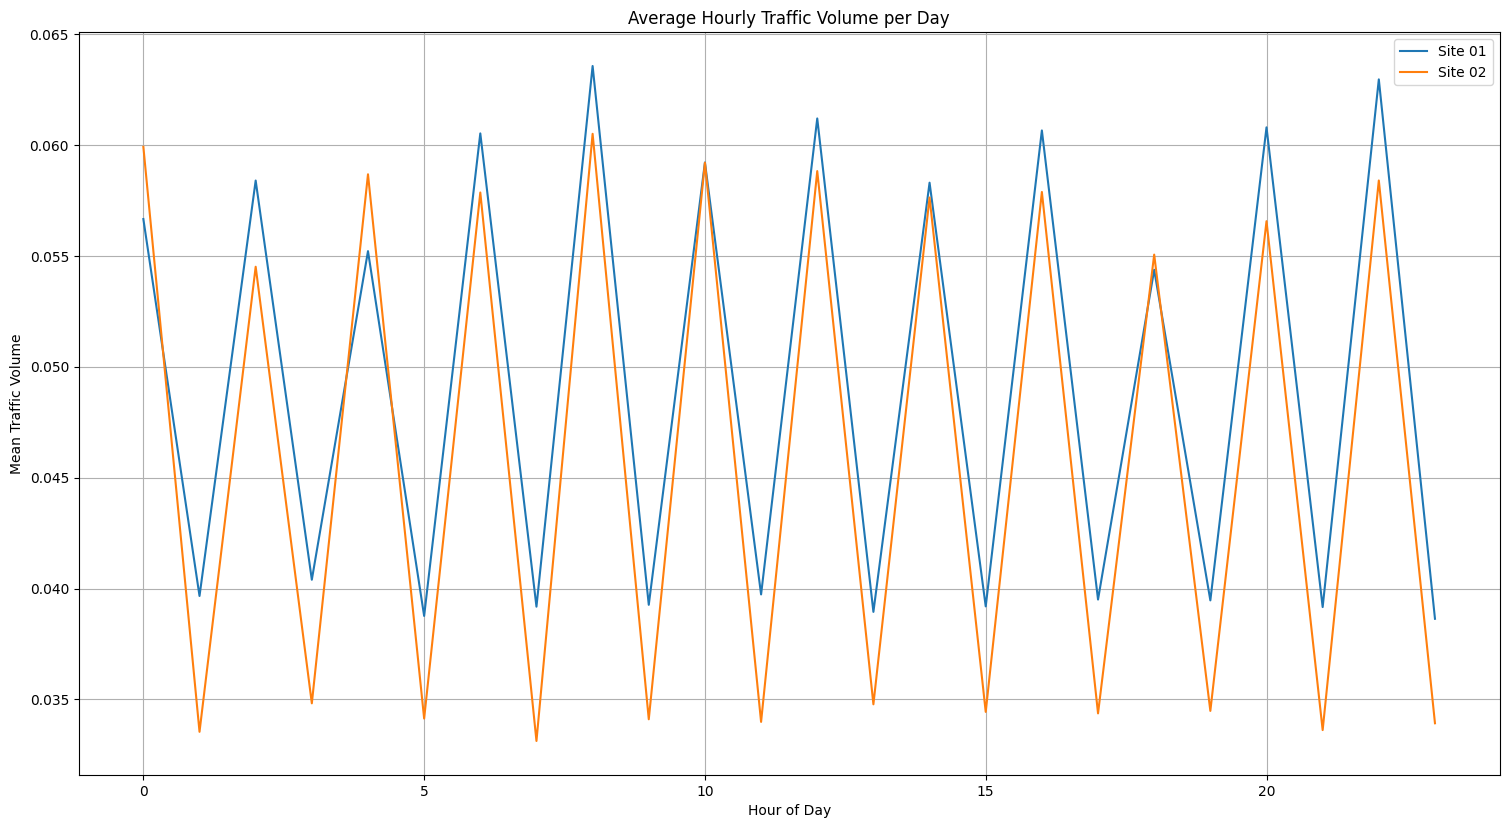

In [ ]:
df['hours'] = (df.index % 288) // 12

plt.figure(figsize=(15, 8))
plt.plot(df.groupby('hours')[[0,1]].mean())
plt.grid(True)
plt.tight_layout()
plt.xlabel('Hour of Day')
plt.ylabel('Mean Traffic Volume')
plt.title('Average Hourly Traffic Volume per Day')
plt.legend(['Site 01', 'Site 02'])
plt.show()


In [ ]:
date_range = pd.date_range(start='2015-01-01', periods=len(df), freq='5min')
df['month'] = date_range.month

In [ ]:
df.drop(columns='hours').groupby('month')[[0,1,2]].mean()

,0,1,2
month,,,
1,0.047980,0.046711,0.104251
2,0.051011,0.045899,0.107832
3,0.046430,0.036480,0.103387


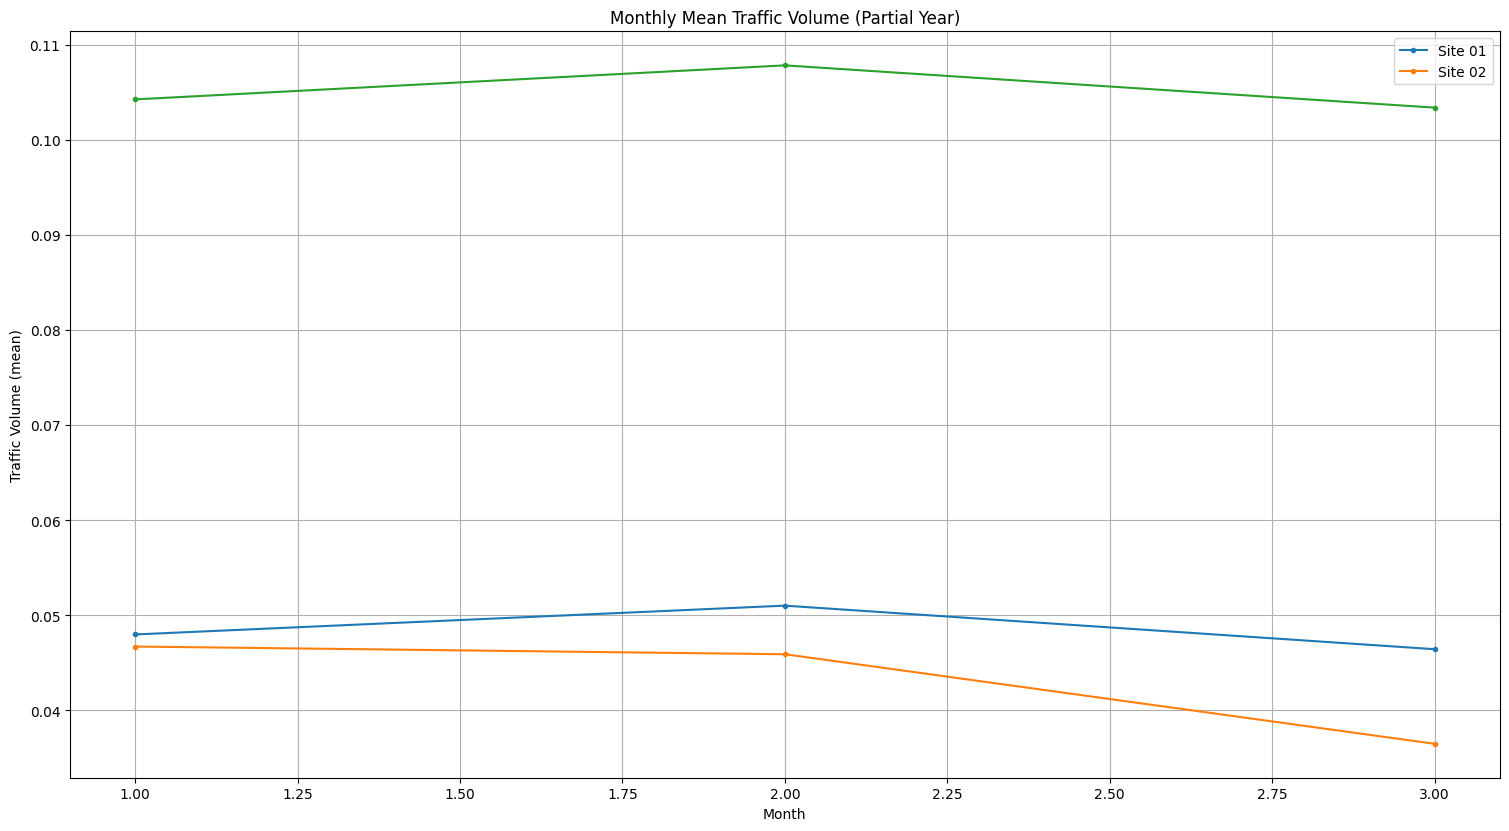

In [ ]:
monthly_avg = df.drop(columns='hours').groupby('month')[[0,1,2]].mean()

plt.figure(figsize=(15, 8))
plt.plot(monthly_avg, marker='.')
plt.grid(True)
plt.tight_layout()
plt.xlabel('Month')
plt.ylabel('Traffic Volume (mean)')
plt.title('Monthly Mean Traffic Volume (Partial Year)')
plt.legend(['Site 01', 'Site 02'])
plt.show()


In [ ]:
sample_sensors = df.columns[:2]
# df[sample_sensors].iloc[:1000].plot(figsize=(15, 6))
# plt.title('Traffic Volume for Sample Sensors (First 1000 steps)')
# plt.show()


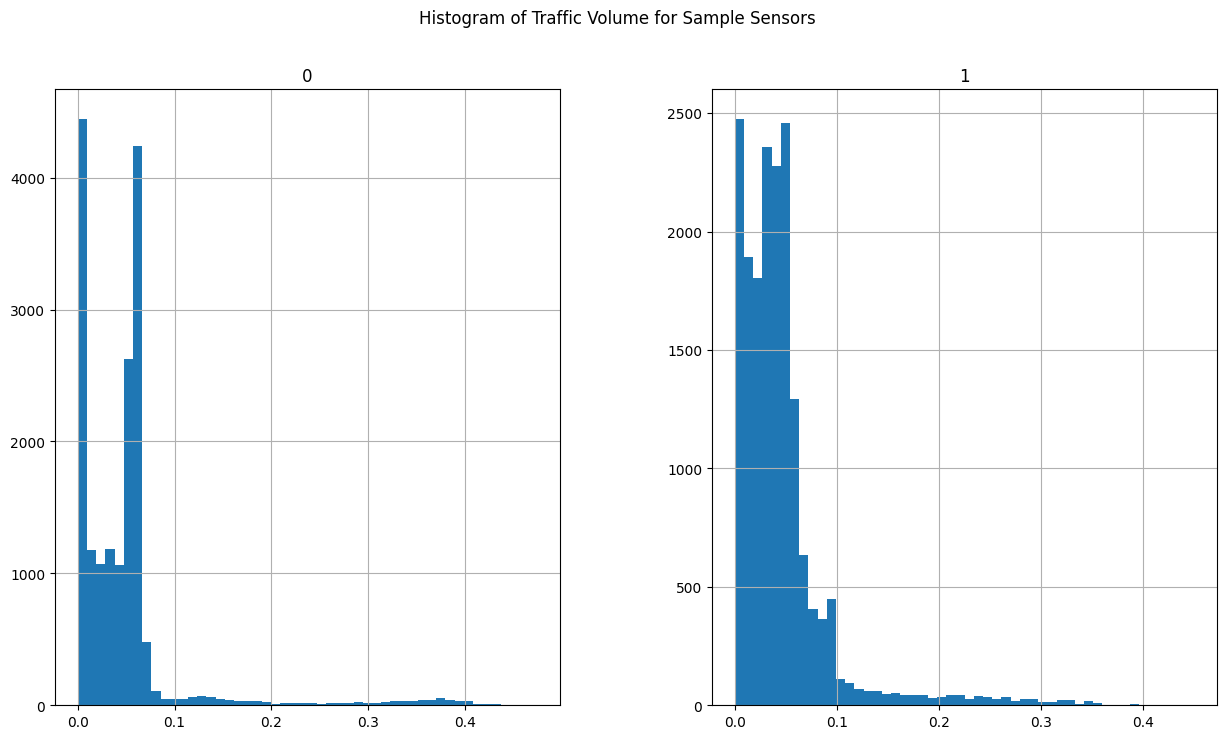

In [ ]:
df[sample_sensors].hist(bins=50, figsize=(15, 8))
plt.suptitle('Histogram of Traffic Volume for Sample Sensors')
plt.show()


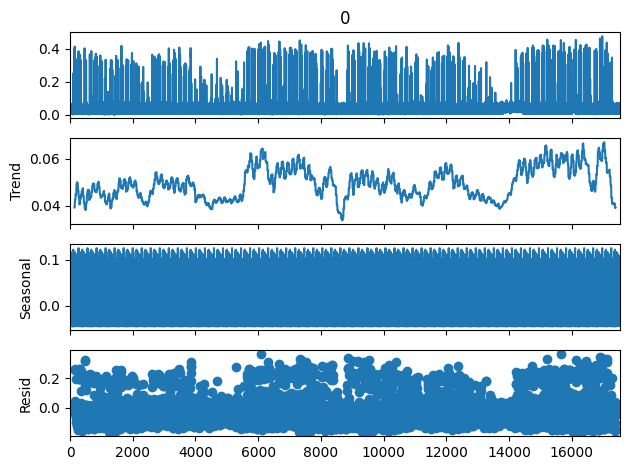

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

rolling_mean = df[sample_sensors].rolling(window=288).mean()
rolling_std = df[sample_sensors].rolling(window=288).std()

result = seasonal_decompose(df[sample_sensors[0]], model='additive', period=288)
result.plot()
plt.show()


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,17544.0,0.049324,0.062469,0.0,0.008900,0.0463,0.0599,0.4747
1,17544.0,0.046016,0.048398,0.0,0.018100,0.0368,0.0537,0.4500
2,17544.0,0.105870,0.082205,0.0,0.035600,0.0810,0.1755,0.4201
3,17544.0,0.056633,0.036746,0.0,0.026800,0.0600,0.0747,0.4947
4,17544.0,0.026812,0.035872,0.0,0.007875,0.0190,0.0243,0.4069
...,...,...,...,...,...,...,...,...
859,17544.0,0.043058,0.023567,0.0,0.027800,0.0412,0.0638,0.3532
860,17544.0,0.029241,0.017606,0.0,0.014100,0.0318,0.0393,0.4159
861,17544.0,0.031537,0.019453,0.0,0.012500,0.0341,0.0467,0.2174
hours,17544.0,11.484952,6.915117,0.0,5.000000,11.0000,17.0000,23.0000


In [ ]:
df.drop(columns=['hours', 'month'], inplace=True)

# Preprocess

In [ ]:
# scaler = MinMaxScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled = df.copy()

In [ ]:
split_ratio = 0.8
split_idx = int(len(df_scaled) * split_ratio)
df_train = df_scaled.iloc[:split_idx]
df_test = df_scaled.iloc[split_idx:]

In [ ]:
12*60/5

144.0

In [ ]:
144*5/60

12.0

In [ ]:
24*5/60

2.0

In [ ]:
window_size = 168
forecast_horizon = 24   # 2 hours = 24 * 5min
batch_size = 16
n_nodes = df_train.shape[1]

862

In [ ]:
def dataset_generator(df, win_size, horizon):
    length = len(df) - win_size - horizon
    for i in range(length):
        x = df.iloc[i:i+win_size].values.astype(np.float32)
        y = df.iloc[i+win_size:i+win_size+horizon].values.astype(np.float32)
        yield x, y

def create_tf_dataset(df, win_size, horizon, batch_size):
    output_signature = (
        tf.TensorSpec(shape=(win_size, df.shape[1]), dtype=tf.float32),
        tf.TensorSpec(shape=(horizon, df.shape[1]), dtype=tf.float32),
    )
    ds = tf.data.Dataset.from_generator(
        lambda: dataset_generator(df, win_size, horizon),
        output_signature=output_signature
    )
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset = create_tf_dataset(df_train, window_size, forecast_horizon, batch_size)
test_dataset = create_tf_dataset(df_test, window_size, forecast_horizon, batch_size)

# Modeling: BiLSTM Stack

In [ ]:
# BiLSTM stack
@register_keras_serializable()
class LSTM_Model(tf.keras.Model):
    def __init__(self, n_nodes, hidden_dim=128, horizon=24, dropout_rate=0.2, bi=True, n_stack=1, norm=True, **kwargs):
        super().__init__(**kwargs)
        self.n_nodes = n_nodes
        self.horizon = horizon
        self.n_stack = n_stack
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.bi = bi
        self.norm = norm
        self.norm1 = tf.keras.layers.LayerNormalization()

        if bi:
          if n_stack <= 1:
            self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim, return_sequences=False))
          else:
            self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim, return_sequences=True))
          self.lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim, return_sequences=False))
        else:
          if n_stack <= 1:
            self.lstm1 = tf.keras.layers.LSTM(hidden_dim, return_sequences=False)
          else:
            self.lstm1 = tf.keras.layers.LSTM(hidden_dim, return_sequences=True)
          self.lstm2 = tf.keras.layers.LSTM(hidden_dim, return_sequences=False)

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.fc = tf.keras.layers.Dense(horizon * n_nodes)

    def call(self, x):
        if self.norm :
          x = self.norm1(x)
        for i in range(self.n_stack - 1):
          x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.dropout(x)
        x = self.fc(x)
        return tf.reshape(x, (-1, self.horizon, self.n_nodes))


    def get_config(self):
        config = super().get_config()
        config.update({
            "n_nodes": self.n_nodes,
            "hidden_dim": self.hidden_dim,
            "horizon": self.horizon,
            "dropout_rate":self.dropout_rate,
            "bi" : self.bi,
            "n_stack":self.n_stack,
            "norm": self.norm
        })
        return config

In [ ]:
n_nodes = df_train.shape[1]
hidden_dim = 64
forecast_horizon = 24

model = LSTM_Model(
                    n_nodes = n_nodes,
                    hidden_dim = hidden_dim,
                    horizon = forecast_horizon,
                    dropout_rate = 0.25,
                    bi = False,
                    n_stack=3,
                    norm=False
                  )

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

early_stopping = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=50, callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'lstm__model_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


867/867 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - loss: 0.0102 - mae: 0.0636 - val_loss: 0.0063 - val_mae: 0.0441
Epoch 2/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - loss: 0.0047 - mae: 0.0387 - val_loss: 0.0057 - val_mae: 0.0417
Epoch 3/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 32s 37ms/step - loss: 0.0040 - mae: 0.0347 - val_loss: 0.0055 - val_mae: 0.0403
Epoch 4/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - loss: 0.0037 - mae: 0.0325 - val_loss: 0.0051 - val_mae: 0.0381
Epoch 5/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 71s 36ms/step - loss: 0.0034 - mae: 0.0306 - val_loss: 0.0051 - val_mae: 0.0380
Epoch 6/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 32s 37ms/step - loss: 0.0033 - mae: 0.0298 - val_loss: 0.0052 - val_mae: 0.0385
Epoch 7/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - loss: 0.0033 - mae: 0.0300 - val_loss: 0.0049 - val_mae: 0.0366
Epoch 8/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - loss: 0.0032 - mae: 0.0289 - val_loss: 0.0048 - val_mae: 0.0362
Epoch 9/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/st

# Patched TalNet: TalNetv2

In [ ]:
@tf.keras.utils.register_keras_serializable()
class TalNetV2(tf.keras.Model):
    def __init__(self, n_nodes, horizon, n_heads=4, hidden_dim=128, dropout_rate=0.1,
                 bi=False, n_stack=1, en_norm=False, node_emb_dim=16, **kwargs):
        super().__init__(**kwargs)
        self.n_nodes = n_nodes
        self.horizon = horizon
        self.n_heads = n_heads
        self.hidden_dim = hidden_dim
        self.n_stack = n_stack
        self.dropout_rate = dropout_rate
        self.bi = bi
        self.en_norm = en_norm
        self.node_emb_dim = node_emb_dim

        self.node_embedding = tf.keras.layers.Embedding(input_dim=n_nodes, output_dim=node_emb_dim)
        self.norm = tf.keras.layers.LayerNormalization()
        self.temporal_conv = tf.keras.layers.Conv1D(
            filters=hidden_dim, kernel_size=3,
            padding='causal', activation='relu'
        )

        if bi:
            self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim, return_sequences=True))
            self.lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim // 2, return_sequences=False))
            self.d_model = hidden_dim * 2
        else:
            self.lstm1 = tf.keras.layers.LSTM(hidden_dim, return_sequences=True)
            self.lstm2 = tf.keras.layers.LSTM(hidden_dim // 2, return_sequences=False)
            self.d_model = hidden_dim

        self.transformer_blocks = []
        for _ in range(n_stack):
            self.transformer_blocks.append({
                "attn": tf.keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=self.d_model),
                "attn_add": tf.keras.layers.Add(),
                "attn_norm": tf.keras.layers.LayerNormalization(),
                "ffn": tf.keras.Sequential([
                    tf.keras.layers.Dense(2 * self.d_model, activation='relu'),
                    tf.keras.layers.Dense(self.d_model),
                ]),
                "ffn_add": tf.keras.layers.Add(),
                "ffn_norm": tf.keras.layers.LayerNormalization()
            })

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.fc = tf.keras.layers.Dense(horizon * n_nodes)

    def call(self, x):
        if self.en_norm:
            x = self.norm(x)

        batch_size = tf.shape(x)[0]
        time_steps = tf.shape(x)[1]

        node_ids = tf.range(self.n_nodes)
        node_emb = self.node_embedding(node_ids)
        node_emb_exp = tf.expand_dims(node_emb, 0)
        node_emb_exp = tf.expand_dims(node_emb_exp, 0)
        node_emb_tiled = tf.tile(node_emb_exp, [batch_size, time_steps, 1, 1])

        x_exp = tf.expand_dims(x, -1)
        x_concat = tf.concat([x_exp, node_emb_tiled], axis=-1)

        x_reshaped = tf.reshape(x_concat, [batch_size * self.n_nodes, time_steps, 1 + self.node_emb_dim])
        x_conv = self.temporal_conv(x_reshaped)
        x_conv_reshaped = tf.reshape(x_conv, [batch_size, time_steps, self.n_nodes, self.hidden_dim])
        x_for_lstm = tf.reshape(x_conv_reshaped, [batch_size, time_steps, self.n_nodes * self.hidden_dim])

        x_lstm1 = self.lstm1(x_for_lstm)

        x = x_lstm1
        for block in self.transformer_blocks:
            attn_out = block["attn"](x, x, x)
            x = block["attn_add"]([x, attn_out])
            x = block["attn_norm"](x)

            ffn_out = block["ffn"](x)
            x = block["ffn_add"]([x, ffn_out])
            x = block["ffn_norm"](x)

        x_lstm2 = self.lstm2(x)
        x_drop = self.dropout(x_lstm2)
        x_out = self.fc(x_drop)
        out = tf.reshape(x_out, [batch_size, self.horizon, self.n_nodes])

        return out

    def get_config(self):
        config = super().get_config()
        config.update({
            "n_nodes": self.n_nodes,
            "horizon": self.horizon,
            "n_heads": self.n_heads,
            "hidden_dim": self.hidden_dim,
            "dropout_rate": self.dropout_rate,
            "bi": self.bi,
            "n_stack": self.n_stack,
            "en_norm": self.en_norm,
            "node_emb_dim": self.node_emb_dim
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [ ]:
model = TalNetV2(
    n_nodes=n_nodes,
    horizon=forecast_horizon,
    n_heads=6,
    hidden_dim=32,
    dropout_rate=0.2,
    bi=True,
    n_stack=1,
    en_norm=False,
    node_emb_dim=8
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mse',
    metrics=['mae']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    callbacks=[early_stopping]
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'tal_net_v2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


    866/Unknown 140s 148ms/step - loss: 0.0020 - mae: 0.0276

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


866/866 ━━━━━━━━━━━━━━━━━━━━ 152s 162ms/step - loss: 0.0020 - mae: 0.0276 - val_loss: 0.0012 - val_mae: 0.0182
Epoch 2/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 138s 160ms/step - loss: 7.8073e-04 - mae: 0.0150 - val_loss: 0.0011 - val_mae: 0.0169
Epoch 3/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 138s 159ms/step - loss: 6.9163e-04 - mae: 0.0136 - val_loss: 0.0010 - val_mae: 0.0164
Epoch 4/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 138s 159ms/step - loss: 6.6172e-04 - mae: 0.0131 - val_loss: 9.7622e-04 - val_mae: 0.0160
Epoch 5/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 138s 159ms/step - loss: 6.3815e-04 - mae: 0.0127 - val_loss: 9.2894e-04 - val_mae: 0.0155
Epoch 6/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 138s 159ms/step - loss: 6.2238e-04 - mae: 0.0125 - val_loss: 9.1621e-04 - val_mae: 0.0153
Epoch 7/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 142s 164ms/step - loss: 6.1216e-04 - mae: 0.0123 - val_loss: 9.0490e-04 - val_mae: 0.0151
Epoch 8/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 138s 159ms/step - loss: 6.0845e-04 - mae: 0.0122 - val_loss: 8.9702e-04 - val

In [ ]:
def step_rse_corr(y_true, y_pred, step):
    yt = y_true[:, :step, :].reshape(-1)
    yp = y_pred[:, :step, :].reshape(-1)
    rse = np.sqrt(np.sum((yt - yp) ** 2) / (np.sum((yt - np.mean(yt)) ** 2) + 1e-8))
    corr, _ = pearsonr(yt, yp)
    return rse, corr

In [ ]:
def step_all_metrics(y_true, y_pred, step):
    yt = y_true[:, :step, :].reshape(-1)
    yp = y_pred[:, :step, :].reshape(-1)

    mse = mean_squared_error(yt, yp)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(yt, yp)
    r2 = r2_score(yt, yp)
    smape = 100 * np.mean(2 * np.abs(yt - yp) / (np.abs(yt) + np.abs(yp) + 1e-8))
    rse = np.sqrt(np.sum((yt - yp)**2) / (np.sum((yt - np.mean(yt))**2) + 1e-8))
    corr, _ = pearsonr(yt, yp)

    return {
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape,
        'RSE': rse,
        'CORR': corr
    }

In [ ]:
# Collect y_test from the test_dataset
y_test = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)


In [ ]:
y_pred = model.predict(test_dataset)

208/208 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
print(f'Model Name: Stacked BiLSTM')
for step in [3, 6, 12, 24]:
    rse, corr = step_rse_corr(y_test, y_pred, step)
    print(f"Step {str(step):3s}--> RSE={rse:.4f}, CORR={corr:.4f}")

Model Name: Stacked BiLSTM
Step 3  --> RSE=0.4782, CORR=0.8784
Step 6  --> RSE=0.4811, CORR=0.8769
Step 12 --> RSE=0.4839, CORR=0.8752
Step 24 --> RSE=0.4901, CORR=0.8714


In [ ]:
print(f'Model Name: TalNetV2')
for step in [3, 6, 12, 24]:
    m = step_all_metrics(y_test, y_pred, step)
    print(f"Step {step:2d} --> R²={m['R2']:.4f}, RMSE={m['RMSE']:.4f}, MAE={m['MAE']:.4f}, "
          f"MSE={m['MSE']:.4f}, SMAPE={m['SMAPE']:.2f}%, RSE={m['RSE']:.4f}, CORR={m['CORR']:.4f}")


Model Name: TalNetV2
Step  3 --> R²=0.7445, RMSE=0.0290, MAE=0.0144, MSE=0.0008, SMAPE=31.34%, RSE=0.5055, CORR=0.8630
Step  6 --> R²=0.7390, RMSE=0.0293, MAE=0.0146, MSE=0.0009, SMAPE=32.02%, RSE=0.5109, CORR=0.8598
Step 12 --> R²=0.7372, RMSE=0.0294, MAE=0.0147, MSE=0.0009, SMAPE=32.34%, RSE=0.5126, CORR=0.8587
Step 24 --> R²=0.7336, RMSE=0.0296, MAE=0.0147, MSE=0.0009, SMAPE=32.32%, RSE=0.5161, CORR=0.8565


In [ ]:
# model.save('/content/drive/MyDrive/data/varsity/traffic_biLSTM.keras')
model.save('/content/drive/MyDrive/data/varsity/TelNetV2_traffic.keras')

In [ ]:
# model = load_model(
#     '/content/drive/MyDrive/data/varsity/traffic_biLSTM.keras',
#     custom_objects={'LSTM_Model': LSTM_Model}
# )


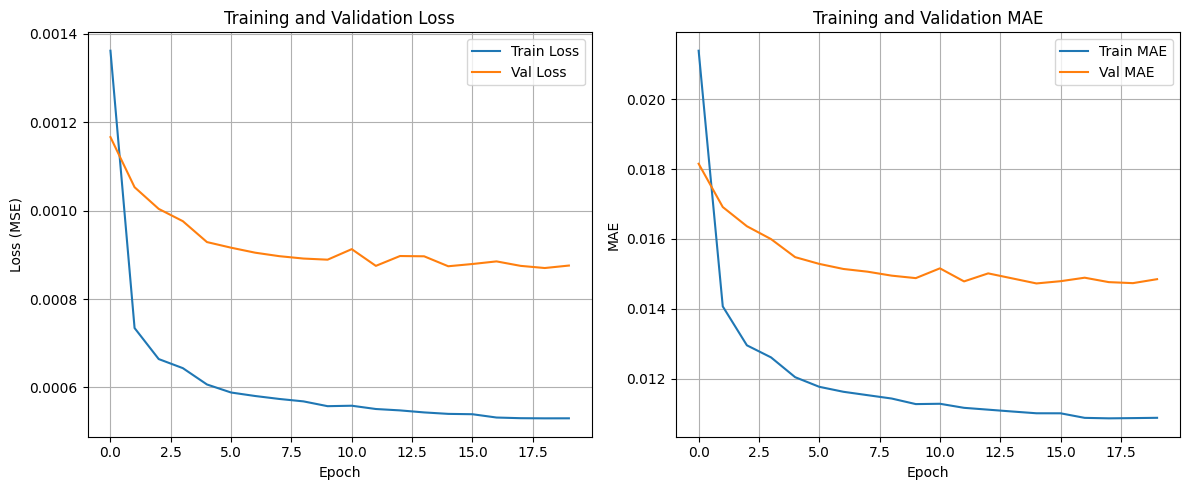

In [ ]:
history_dict = history.history

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Train MAE')
plt.plot(history_dict['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
model.save('/content/drive/MyDrive/data/varsity/TalNetV2_traffic.keras')

In [ ]:
# model = load_model(
#     '/content/drive/MyDrive/data/varsity/TalNetV2_traffic.keras',
#     custom_objects={'TalNetV2': TalNetV2}
# )